In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd as autograd   

import torch
import pandas as pd

from scipy.interpolate import LinearNDInterpolator
device1 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print("Device 1: ",device1)
print("Device 2: ",device2)

Device 1:  cuda:2
Device 2:  cuda:3


In [2]:
# folder_main = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Experimental_Comparison_Only/ExperimentalData_and_Plots/'
# filename = 'Models_Trained_AFSD_Exp_2mms_z1mm_300rpm_2mms_8.pt'
filename = 'AFSD_Exp_calib_300rpm_2mms.pt'
data_filename = 'Exponential_300_2mms.mat'

R0 = 5.36 #mm 5.36
Rs = 19 #mm
mu_vis = 0.3 
mu = 0.3 #Friction Coefficient (not viscosity)
delta = 0.5
A = 6.41 #For slip factor
pi = np.pi
Omega = 300 #rpm
V = 2 #mm/s
F = 0.67 #mm
rho = 2700 * 1e-6 #g/mm3
k_B = 1.380649*1e-23 #J/K
R = 8.314 #J/(K.mol)
E_a = 205000 #J/mol #Q
alpha_sig = 52 #mm^2/(kN)
# A = np.exp(27.78)
log_A = 27.78
n = 3.49

k = 0.167 #Thermal Conductivity #W/(mmK)
c_p = 0.897 #J/gK 
alpha_m = k/(rho*c_p)
T_a = 298.0


k_t = 0.0176 #W/(mmK)
c_p_t = 0.46 #J/gk
rho_t = 7750 * 1e-6 #g/mm3
alpha_t = k_t/(rho_t*c_p_t)

h_sides = 5*1e-6 #W/mm^2K
C_bot = 0.15*1e-6 #W/mm^2K^3

eeta = alpha_m/(alpha_m+alpha_t)

lb_xyz_uvw = np.array([-50.0,-20.0,-3.0])
ub_xyz_uvw = np.array([50.0,20.0,0.0])


lb_xyz = np.array([-50.0,-20.0,-3.0])
ub_xyz = np.array([50.0,20.0,0.0])


In [3]:
sheet_name  = '300rpm_2mms'
Exp_data_filename = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Experimental_Comparison_Only/ExperimentalData_and_Plots/Experimental_Data_Full.xlsx'
data_exp = pd.read_excel(Exp_data_filename,sheet_name=sheet_name,header = None)
data_exp= pd.DataFrame.to_numpy(data_exp)

In [4]:
from Seq_Model_Parallel_calibration import coupled_PINN

layers1 = np.array([3,50,50,50,4]) #9 hidden layers
layers2 = np.array([3,50,50,50,1]) #9 hidden layers
# layers = np.array([3,50,50,50,5])
# layers = np.array([3,64,64,64,1])
model_PINN = coupled_PINN(layers1,layers2,device1,device2,lb_xyz,ub_xyz,sheet_name)

model_PINN.load_state_dict(torch.load(filename))

#Testing with FVM data
fvm_data = loadmat('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/Data/AFSD_Nikhil/' + data_filename)

u_fvm = fvm_data['u_star']
v_fvm = fvm_data['v_star']
w_fvm = fvm_data['w_star']

u_fvm = (u_fvm[0:-1,:,:] + u_fvm[1:,:,:])/2
v_fvm = (v_fvm[:,0:-1,:] + v_fvm[:,1:,:])/2
w_fvm = (w_fvm[:,:,0:-1] + w_fvm[:,:,1:])/2


Res_v_fvm = np.sqrt(np.square(u_fvm) + np.square(v_fvm) + np.square(w_fvm))
T_fvm = fvm_data['T']
# sigma_e_fvm = fvm_data['effectivestress']
# eps_e_fvm = fvm_data['effstrrate']
# mu_vis_fvm = fvm_data['mu']

Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=4, bias=True)
  )
)
Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)


/home/smartlab/anaconda3/envs/raghav/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
# PLOTTING
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

x_min = -8.0
x_max = 8.0

z_min = 0.0
z_max = -1.0

x = np.linspace(x_min,x_max,17).reshape(-1,1)
# y = np.linspace(y_min,y_max,200).reshape(-1,1)
y = 20.0
z = np.linspace(z_min,z_max,5).reshape(-1,1)
# z = -0.4
X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()
T = model_PINN.PINN_T.forward(xyz_test_tensor.to(device2)).cpu().detach().numpy()
T = T.reshape(5,17)

In [6]:
data_exp

array([[632.        , 629.46140014, 624.48138449, 623.27992171,
        622.8654302 ],
       [648.72984877, 645.13273209, 644.03394923, 642.58707816,
        641.01593988],
       [660.        , 657.12590718, 655.30638366, 652.14111078,
        649.21087273],
       [672.27314829, 669.05049798, 667.97647348, 668.57688874,
        667.32004821],
       [685.        , 682.79621319, 682.1749655 , 680.03739043,
        675.9406604 ],
       [689.87591802, 684.95638368, 683.57150742, 685.22771508,
        680.69052139],
       [700.        , 700.53530371, 701.97428715, 701.0342715 ,
        700.46490249],
       [706.22641261, 705.30152603, 708.38476563, 706.05432749,
        700.7157323 ],
       [707.        , 706.68089539, 706.28196745, 703.53362041,
        699.16641376],
       [705.07209645, 701.90969222, 702.20398751, 698.87084   ,
        691.48732467],
       [698.        , 697.17847062, 698.88633539, 699.10955034,
        694.80563229],
       [693.75496838, 697.68133916, 698.836

In [7]:
np.sqrt(np.mean(np.square(np.flip(T.reshape(17,5)) - data_exp)))

36.90181199753672

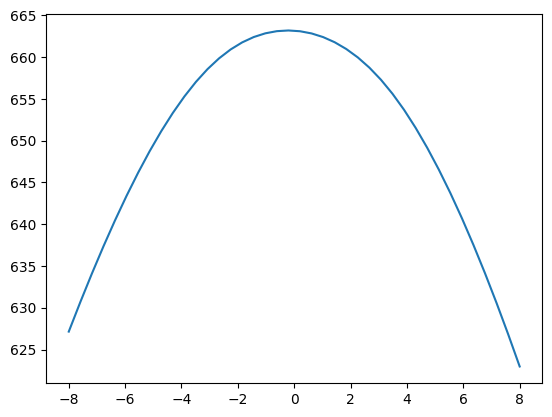

In [8]:
x_real = np.linspace(x_min,x_max,17).reshape(-1,1)
x_fvm = np.linspace(x_min,x_max,40).reshape(-1,1)
plt.plot(x_fvm,np.mean(T_fvm[105:145,99,:4],axis = 1))

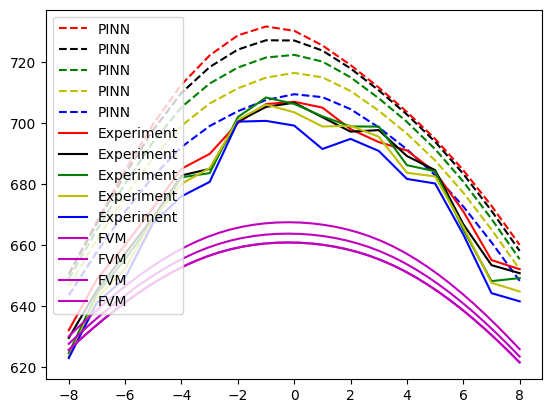

In [9]:

fig,ax = plt.subplots()
ax.plot(x,np.flip(T[0,:]),'r--',label='PINN')
ax.plot(x,np.flip(T[1,:]),'k--',label='PINN')
ax.plot(x,np.flip(T[2,:]),'g--',label='PINN')
ax.plot(x,np.flip(T[3,:]),'y--',label='PINN')
ax.plot(x,np.flip(T[4,:]),'b--',label='PINN')



ax.plot(x_real,data_exp[:,0],'r',label = 'Experiment')
ax.plot(x_real,data_exp[:,1],'k',label = 'Experiment')
ax.plot(x_real,data_exp[:,2],'g',label = 'Experiment')
ax.plot(x_real,data_exp[:,3],'y',label = 'Experiment')
ax.plot(x_real,data_exp[:,4],'b',label = 'Experiment')

x_fvm = np.linspace(x_min,x_max,40).reshape(-1,1)
ax.plot(x_fvm,T_fvm[105:145,99,0],'m',label = 'FVM')
ax.plot(x_fvm,T_fvm[105:145,99,1],'m',label = 'FVM')
ax.plot(x_fvm,T_fvm[105:145,99,2],'m',label = 'FVM')
ax.plot(x_fvm,T_fvm[105:145,99,3],'m',label = 'FVM')


ax.legend()

In [1]:
fig,ax = plt.subplots()
ax.plot(x,np.mean(T,axis = 0),'k',label='PINN')
ax.plot(x_real,np.mean(data_exp[:,0:5],axis = 1),'ro',label = 'Experiment')
ax.plot(x_fvm,np.mean(T_fvm[105:145,99,:4],axis = 1),'b',label = 'FVM')


# ax.plot(data_exp_300_2mms[:,p_base+4],'r-.',label = 'Experiment')
# ax.plot(data_exp_300_2mms[:,p_base+3],'k',label = 'Experiment')
# ax.plot(data_exp_300_2mms[:,p_base+2],'g',label = 'Experiment')
# ax.plot(data_exp_300_2mms[:,p_base+1],'y',label = 'Experiment')
# ax.plot(data_exp_300_2mms[:,p_base],'b',label = 'Experiment')
ax.legend()

NameError: name 'plt' is not defined

In [66]:
#Tracing Points
xyz_start = np.array([0.0,0.0,-0.01])

n_timesteps = 2000




xyz_trace = np.zeros((n_timesteps+1,3))
eps_e_trace = np.zeros((n_timesteps))

xyz_trace[0] = xyz_start 
xyz = xyz_trace[0]

for t in range(n_timesteps):
    xyz_tensor = torch.from_numpy(xyz).float().to(device1)
    uvwp = model_PINN.PINN_uvw.forward(xyz_tensor).cpu().detach().numpy()

    dx = uvwp[0]/10000.0
    dy = uvwp[1]/10000.0
    dz = uvwp[2]/10000.0
    
    xyz = xyz + np.array([dx,dy,dz])


    g = xyz_tensor.reshape(1,-1).clone()
    g.requires_grad = True

    out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
    u = out_full[:,0:1]
    v = out_full[:,1:2]
    w = out_full[:,2:3]
    p = out_full[:,3:4]


    # print(T.shape)
    T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

    # print(u.shape)
    [ront]

    # p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
    u_xyz = autograd.grad(u,g,torch.ones([g.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
    v_xyz = autograd.grad(v,g,torch.ones([g.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
    w_xyz = autograd.grad(w,g,torch.ones([g.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

    eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
    eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
    eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

    eps2_21 = eps2_12
    eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
    eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

    eps2_31 = eps2_13
    eps2_32 = eps2_23 
    eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

    eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)

    eps_e_trace[t] = eps_e

    xyz_trace[t+1,:] = xyz

KeyboardInterrupt: 

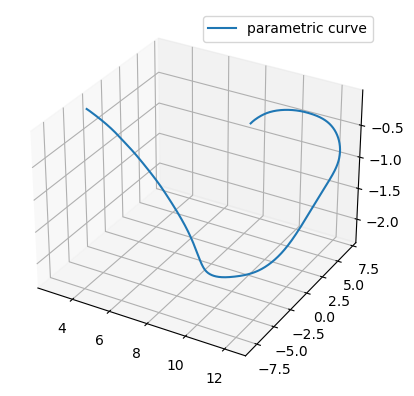

In [162]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(xyz_trace[:,0], xyz_trace[:,1], xyz_trace[:,2], label='parametric curve')
ax.legend()

plt.show()

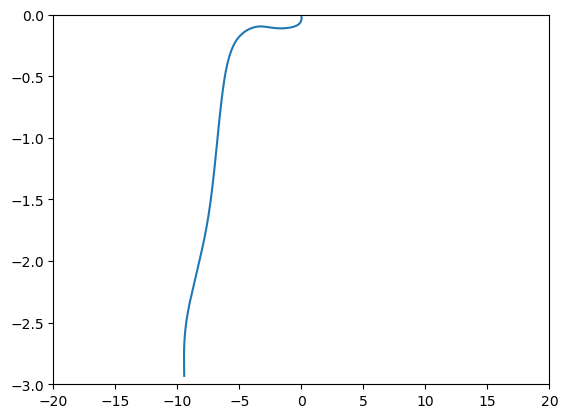

In [166]:
fig,ax = plt.subplots()
ax.plot(xyz_trace[:,0], xyz_trace[:,2], label='parametric curve')
ax.set_xlim([-20,20])
ax.set_ylim([-3.0,0.0])
# ax.set_ylim([-20,20])
# ax.legend()

plt.show()

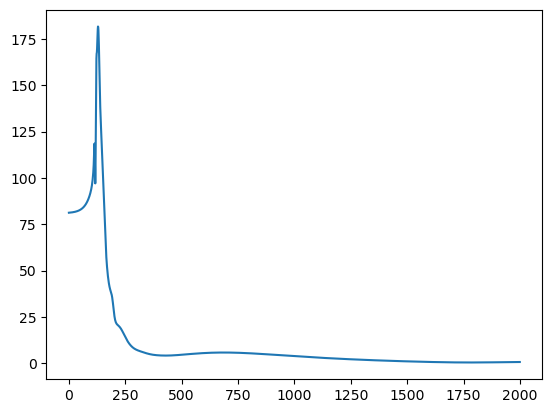

In [167]:
plt.plot(eps_e_trace)

In [154]:
z.shape

(100,)

In [155]:
# g = xyz_test_tensor.clone()
# g.requires_grad = True

# out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
# u = out_full[:,0:1]
# v = out_full[:,1:2]
# w = out_full[:,2:3]
# p = out_full[:,3:4]


# # print(T.shape)
# T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# # p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
# u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
# v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
# w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

# eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
# eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
# eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

# eps2_21 = eps2_12
# eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
# eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

# eps2_31 = eps2_13
# eps2_32 = eps2_23 
# eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

# eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# # Z = eps_e*torch.exp(E_a/(R*T))
# # log_Z = torch.log(eps_e) + E_a/(R*T)
# log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


# W = (log_Z - log_A)/n



# # sigma_e =  (1/alpha_sig)*torch.asinh(W) 
# sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

# #____________________________#
# mu_vis = sigma_e/(3*eps_e)

# T = T.cpu().detach().numpy()
# eps_e = eps_e.cpu().detach().numpy()
# sigma_e = sigma_e.cpu().detach().numpy()
# mu_vis = mu_vis.cpu().detach().numpy()

ValueError: cannot reshape array of size 10000 into shape (200,200)

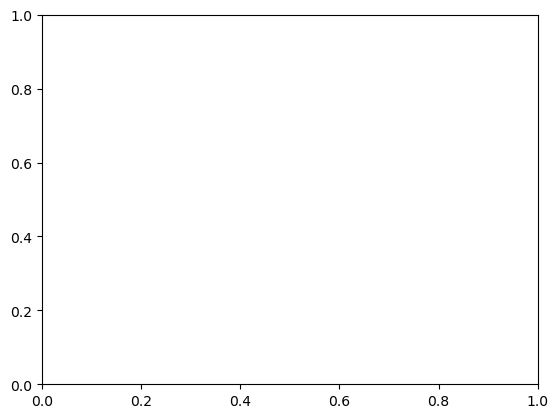

In [20]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((r_vel/1000).reshape(200,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 0.15,vmin = 0)
fig.colorbar(im)
ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_PureSlip.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$y$ (mm)')

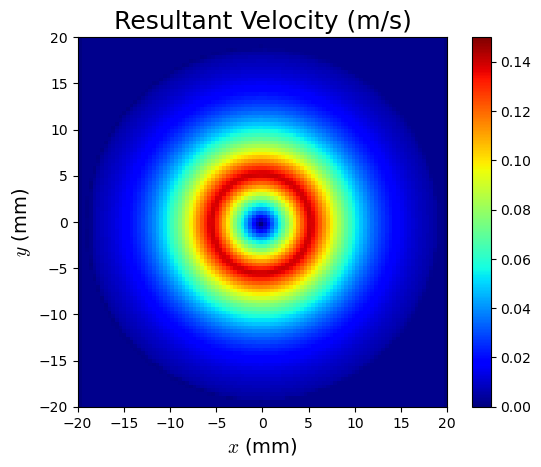

In [21]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(Res_v_fvm[75:175,:,-1],cmap = 'jet',extent = [-20,20,-20,20],vmax = 0.15,vmin = 0)
fig.colorbar(im)
ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('FVM_Res_vel_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

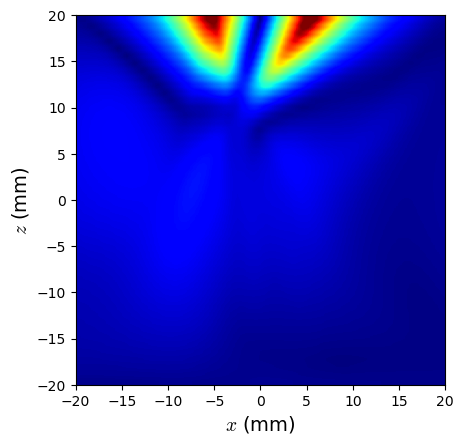

In [23]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((np.flip(r_vel)/1000).reshape(50,200),cmap = 'jet',extent = [-20,20,-3,0],vmax = 0.15,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_PureSlip_xz.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

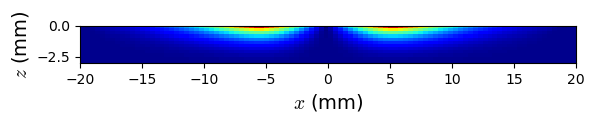

In [24]:
#FVM
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(Res_v_fvm[75:175,49,:])),cmap = 'jet',extent = [-20,20,-3,0],vmax = 0.15,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('FVM_Res_vel_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')

In [25]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)


eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()


ValueError: cannot reshape array of size 10000 into shape (200,200)

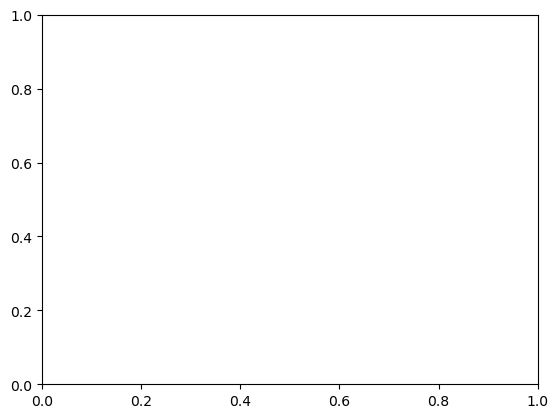

In [26]:
fig,ax = plt.subplots()
im = ax.imshow(T.cpu().detach().numpy().reshape(200,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 800,vmin = 300)
fig.colorbar(im)
ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Temp_xy_Proposal.svg',format = 'svg',bbox_inches = 't

ValueError: cannot reshape array of size 10000 into shape (200,200)

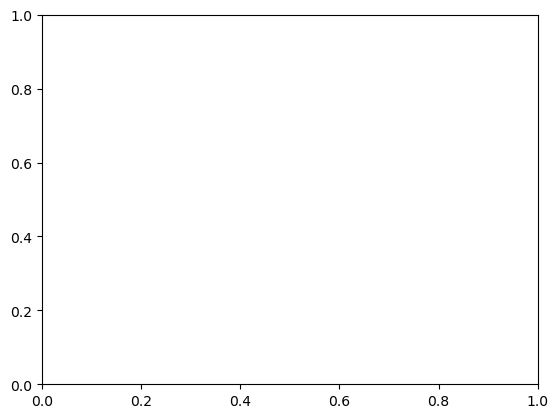

In [27]:
fig,ax = plt.subplots()
im = ax.imshow((eps_e/2).reshape(200,200),cmap = 'viridis',extent = [-20,20,-20,20],vmax = 80,vmin = 0)
fig.colorbar(im)
ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Eps_xy_QSR.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

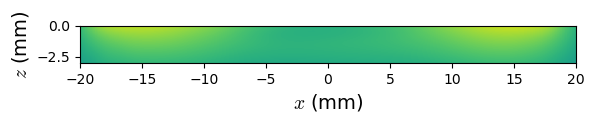

In [31]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(T.cpu().detach().numpy().reshape(50,200)),cmap = 'viridis',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Eps_xz_QSR.svg',format = 'svg',bbox_inches = 'tight')

tensor([763.8500], grad_fn=<UnbindBackward0>)

In [ ]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(eps_e.cpu().detach().numpy().reshape(50,200)),cmap = 'jet',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)

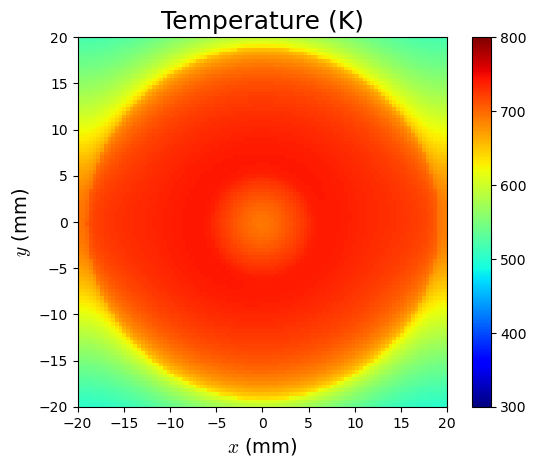

In [33]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(T_fvm[75:175,:,-1],cmap = 'jet',extent = [-20,20,-20,20],vmax = 800,vmin = 300)
fig.colorbar(im)
ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_T_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

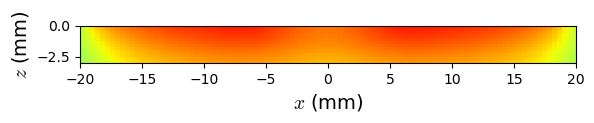

In [29]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(T_fvm[75:175,49,:])),cmap = 'jet',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_T_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')

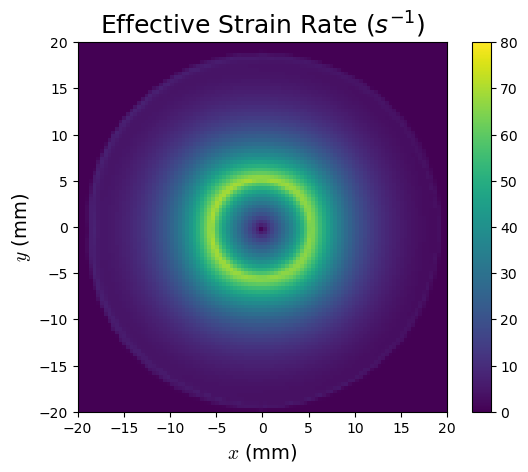

In [77]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(eps_e_fvm[75:175,:,-1],cmap = 'viridis',extent = [-20,20,-20,20],vmax = 80,vmin = 0)
fig.colorbar(im)
ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_eps_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

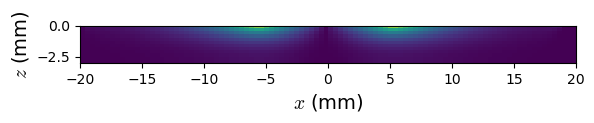

In [78]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(eps_e_fvm[75:175,49,:])),cmap = 'viridis',extent = [-20,20,-3,0],vmax = 80,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_eps_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')